In [1]:
# ------------- MODO DAILY JANEIRO DIAS ÚTEIS ------------- #

# Importando os pacotes necessários
import py_dss_interface
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
mes = "Janeiro"
mes_ = "jan"
n_mes = "01"

In [2]:
# Criando o objeto "dss" e arquivo a ser compilado
dss_file = "C:\Projeto_Final\8500-Node\Master.dss"
dss = py_dss_interface.DSSDLL()

OpenDSS Started successfully! 
OpenDSS Version 9.4.0.1 (64-bit build); License Status: Open 




In [3]:
# ------------- SEM BATERIA ------------- #

# Compilando arquivo com dados do sistema
dss.text("Clear")
dss.text("compile [{}]".format(dss_file))
# Inserindo um medidor de Energia no Alimentador que sai da subestação principal
alimentador = 'Line.ln5815900-1'
dss.text(f"New Energymeter.m1 {alimentador} 1")
# Inserindo um monitor das grandezas elétricas no Alimentador que sai da subestação principal
dss.text(f"New Monitor.m1_power {alimentador} terminal=1 mode=1 ppolar=False")
dss.text(f"New Monitor.m1_voltage {alimentador} terminal=1 mode=0 ppolar=False")
# Definindo itens de controle e iterações do software
dss.text("Set Maxiterations=20")
dss.text("Set maxcontrolit=100")
# Carregando o LoadShape
loadshape = str(f"{n_mes}loadshape_{mes_}_u")
dss.text(f"New LoadShape.{loadshape} npts=24 interval=1 mult=(file={loadshape}.csv)")

# Definindo o LoadShape para todas as cargas
dss.text(f"Batchedit Load..* daily={loadshape}")

# Resolvendo modo daily
dss.text("set mode=daily")
dss.text("set number=24")
dss.text("set stepsize=1h")
dss.solution_solve()

# Ativando Monitor de Potência no Alimentador
dss.monitors_write_name("m1_power")
pa = dss.monitors_channel(1)
qa = dss.monitors_channel(2)
pb = dss.monitors_channel(3)
qb = dss.monitors_channel(4)
pc = dss.monitors_channel(5)
qc = dss.monitors_channel(6)
pt = np.array(pa) + np.array(pb) + np.array(pc)
qt = np.array(qa) + np.array(qb) + np.array(qc)

# Ativando o Monitor de Tensões e Correntes
dss.monitors_write_name("m1_voltage")
v1 = np.round(np.array(dss.monitors_channel(1))/10**3, 3)
v2 = np.round(np.array(dss.monitors_channel(3))/10**3, 3)
v3 = np.round(np.array(dss.monitors_channel(5))/10**3, 3)
v1_pu = np.round(np.array(dss.monitors_channel(1))*math.sqrt(3)/((10**3)*12.47), 3)
v2_pu = np.round(np.array(dss.monitors_channel(3))*math.sqrt(3)/((10**3)*12.47), 3)
v3_pu = np.round(np.array(dss.monitors_channel(5))*math.sqrt(3)/((10**3)*12.47), 3)
i1 = np.round(np.array(dss.monitors_channel(7)), 3)
i2 = np.round(np.array(dss.monitors_channel(9)), 3)
i3 = np.round(np.array(dss.monitors_channel(11)), 3)

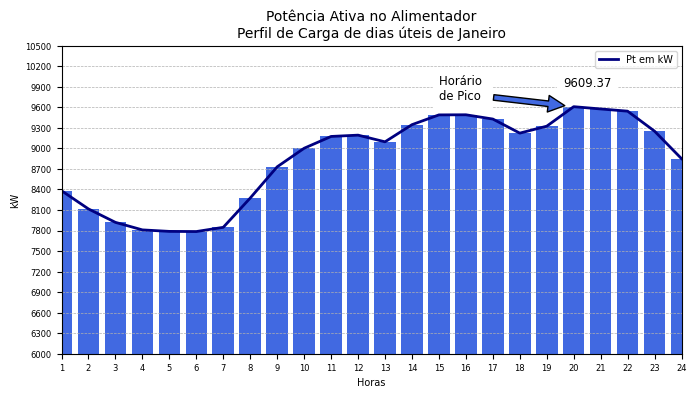

In [68]:
# Gráfico de Potência Ativa Fornecida pelo Alimentador
x = list(range(1, 1 +len(pt)))
y = pt
plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "royalblue")
plt.plot(x,y, "navy", label = 'Pt em kW',linewidth = 2)
plt.title(f"Potência Ativa no Alimentador\nPerfil de Carga de dias úteis de {mes}",fontsize = 'medium')
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(6000,10500)
plt.yticks(np.linspace(6000, 10500, 16, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.annotate('Horário \nde Pico',
            fontsize = 'small',
            backgroundcolor='white',
            xy = (pt.argmax()+1, pt.max()),
            xytext = (pt.argmax()-4, pt.max()+100),
            )
plt.annotate("",
            xy = (pt.argmax()+1, pt.max()),
            fontsize = 'small',
            xytext = (pt.argmax()-2.3, pt.max()+150),
            arrowprops = dict(facecolor='royalblue', shrink=0.1),
            )
plt.annotate(text = repr(round(pt.max(),2)),
            xy=(19.6,9900),
            fontsize='small',
            backgroundcolor='white',
            )
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.show() 

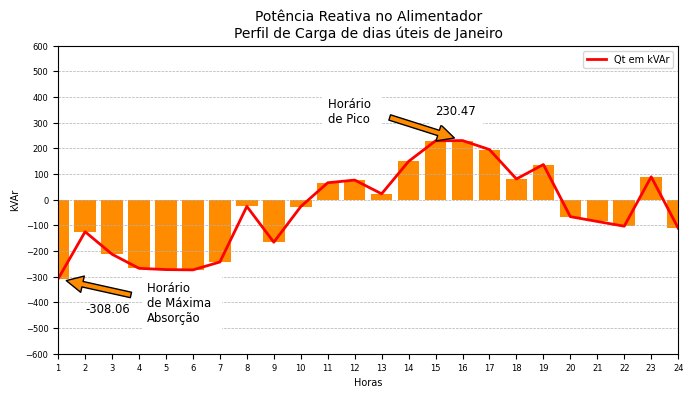

In [12]:
# Gráfico de Potência Reativa fornecida pelo Alimentador
x = list(range(1, 1 +len(qt)))
y = qt
plt.figure(figsize=(8, 4))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.bar(x,y,color = "darkorange")
plt.plot(x,y, "red", label = 'Qt em kVAr',linewidth = 2)
plt.title(f"Potência Reativa no Alimentador\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("kVAr")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(-600,600)
plt.yticks(np.linspace(-600, 600, 13, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

plt.annotate('Horário \nde Pico',
            fontsize = 'small',
            backgroundcolor='white',
            xy=(qt.argmax()+1, qt.max()),
            xytext=(qt.argmax()-4, qt.max()+70),
            )
plt.annotate("",
            xy = (qt.argmax()+1, qt.max()),
            fontsize = 'small',
            xytext = (qt.argmax()-2, qt.max()+100),
            arrowprops = dict(facecolor='darkorange', shrink=0.1)
            )
plt.annotate(text = repr(round(qt.max(),2)),
            xy=(15,330),
            fontsize = 'small',
            backgroundcolor='white'
            )
plt.annotate('Horário \nde Máxima \nAbsorção',
            fontsize = 'small',
            xy=(qt.argmin()+6, qt.min()),
            xytext=(qt.argmin()+4.3, qt.min()-165),
            backgroundcolor='white'
            )
plt.annotate("",
            xy = (qt.argmin()+1, qt.min()),
            fontsize = 'small',
            xytext = (qt.argmin()+4, qt.min()-70),
            arrowprops = dict(facecolor='darkorange', shrink=0.1)
            )
plt.annotate(text = repr(round(qt.min(),2)),
            xy=(2,-440),
            fontsize = 'small'
            )
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

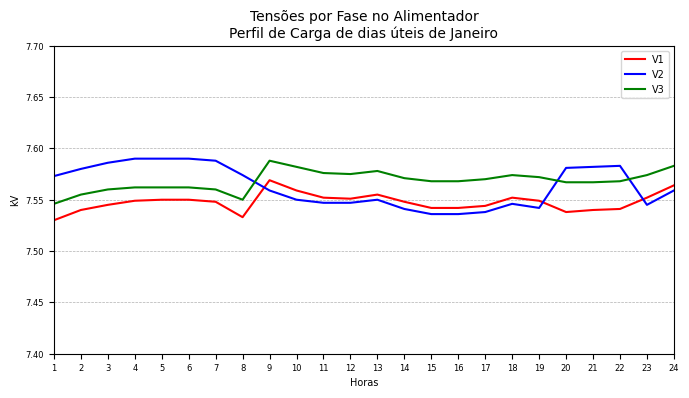

In [13]:
# Tensões por Fase no Alimentador
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(v1))), v1, "r", label = 'V1')
plt.plot(list(range(1, 1 + len(v2))), v2, "b", label = 'V2')
plt.plot(list(range(1, 1 + len(v3))), v3, "g", label = 'V3')
plt.title(f"Tensões por Fase no Alimentador\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("kV")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(7.4,7.7)
plt.yticks(np.linspace(7.4, 7.7, 7, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

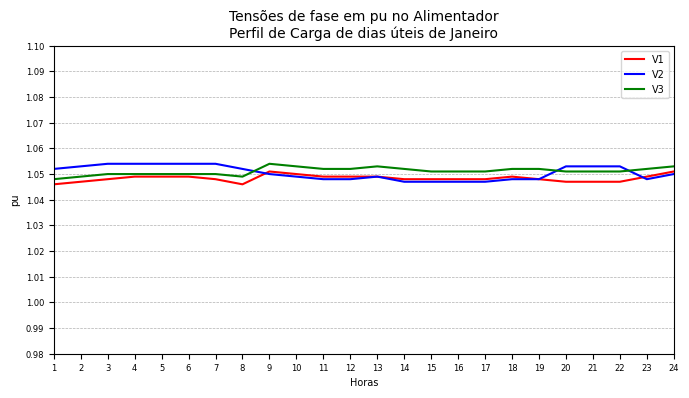

In [14]:
# Tensões em PU por Fase no Alimentador
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(v1_pu))), v1_pu, "r", label = 'V1')
plt.plot(list(range(1, 1 + len(v2_pu))), v2_pu, "b", label = 'V2')
plt.plot(list(range(1, 1 + len(v3_pu))), v3_pu, "g", label = 'V3')
plt.title(f"Tensões de fase em pu no Alimentador\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("pu")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(0.98,1.1)
plt.yticks(np.linspace(0.98, 1.1, 13, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

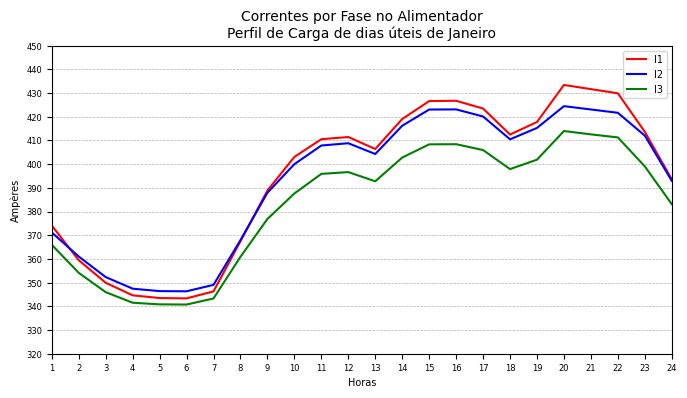

In [15]:
# Corrente por Fase no Alimentador
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(i1))), i1, "r", label = 'I1')
plt.plot(list(range(1, 1 + len(i2))), i2, "b", label = 'I2')
plt.plot(list(range(1, 1 + len(i3))), i3, "g", label = 'I3')
plt.title(f"Correntes por Fase no Alimentador\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("Ampères")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(250,450)
plt.yticks(np.linspace(250, 450, 21, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

In [77]:
# Ativando o medidor do ramal de alimentação
dss.meters_write_name("m1")
reg_meters_names = dss.meters_register_names()
reg_meters_values = dss.meters_register_values()
reg_meters_values = list(map(lambda x: round(x, 2), reg_meters_values))
meters = pd.DataFrame(reg_meters_names, columns=["Medidas"])
meters["Valores"] = reg_meters_values
meters = meters.set_index("Medidas")
meters = meters[(meters['Valores']!=0)]
meters.to_excel(f'C:\Projeto_Final\Tabelas_e_imagens\medidores_{mes_}_u.xlsx')

In [4]:
#-------------- CENÁRIO COM BATERIA - MODO PEAKSHAVE POR POTÊNCIA --------------#

# Compilando arquivo com dados do sistema
dss.text("Clear")
dss.text("compile [{}]".format(dss_file))
# Inserindo um medidor de Energia no Alimentador que sai da subestação principal
alimentador = 'Line.ln5815900-1'
dss.text(f"New Energymeter.m1_b {alimentador} 1")
# Inserindo um monitor das grandezas elétricas no Alimentador que sai da subestação principal
dss.text(f"New Monitor.m1_power {alimentador} terminal=1 mode=1 ppolar=False")
dss.text(f"New Monitor.m1_voltage {alimentador} terminal=1 mode=0 ppolar=False")
# Definindo itens de controle e iterações do software
dss.text("Set Maxiterations=5000")
dss.text("Set maxcontrolit=5000")
# Carregando o LoadShape
loadshape = str(f"{n_mes}loadshape_{mes_}_u")
dss.text(f"New LoadShape.{loadshape} npts=24 interval=1 mult=(file={loadshape}.csv)")
#Definindo o LoadShape para todas as cargas
dss.text(f"Batchedit Load..* daily={loadshape}")

#dss.text("BatchEdit CapControl.. *enabled=False")
#dss.text("BatchEdit RegControl.. *enabled=False")

# Definindo a curva de eficiencia do inversor
dss.text("New XYCurve.Eff npts=4 xarray=[.1 .2 .4 1.0] yarray=[.86 .9 .93 .97]")

# Definindo a Bateria
dss.text("New Storage.Storage1 phases=3 bus1=m1166366 kV=12.47 %idlingkW=1 kwrated=800 kwhrated=2000 dispmode=peakShave %stored=0 EffCurve=Eff vminpu=0.95 vmaxpu=1.05")
dss.text("New Monitor.Storage1 element=Storage.Storage1 mode=3")

dss.text(f"New StorageController.Storage1 element={alimentador} terminal=1 modedis=peakShave MonPhase=AVG kwtarget=9300 modecharge=Time timeChargeTrigger=2 %rateCharge=85 %reserve=0 eventlog=yes")

#resolvendo modo daily
#dss.text("Set maxcontroliter=2000")
dss.text("Set mode=daily")
dss.text("Set number=24")
dss.text("Set stepsize=1h")
dss.solution_solve()
dss.text("Show Eventlog")

# Ativando Monitor de Potência no Alimentador
dss.monitors_write_name("m1_power")
pa1 = dss.monitors_channel(1)
qa1 = dss.monitors_channel(2)
pb1 = dss.monitors_channel(3)
qb1 = dss.monitors_channel(4)
pc1 = dss.monitors_channel(5)
qc1 = dss.monitors_channel(6)
pt1 = np.array(pa1) + np.array(pb1) + np.array(pc1)
qt1 = np.array(qa1) + np.array(qb1) + np.array(qc1)

# Ativando o Monitor de Tensões e Correntes
dss.monitors_write_name("m1_voltage")
v1_b = np.round(np.array(dss.monitors_channel(1))/10**3, 3)
v2_b = np.round(np.array(dss.monitors_channel(3))/10**3, 3)
v3_b = np.round(np.array(dss.monitors_channel(5))/10**3, 3)
v1b_pu = np.round(np.array(dss.monitors_channel(1))*math.sqrt(3)/((10**3)*12.47), 3)
v2b_pu = np.round(np.array(dss.monitors_channel(3))*math.sqrt(3)/((10**3)*12.47), 3)
v3b_pu = np.round(np.array(dss.monitors_channel(5))*math.sqrt(3)/((10**3)*12.47), 3)
i1_b = np.round(np.array(dss.monitors_channel(7)), 3)
i2_b = np.round(np.array(dss.monitors_channel(9)), 3)
i3_b = np.round(np.array(dss.monitors_channel(11)), 3)

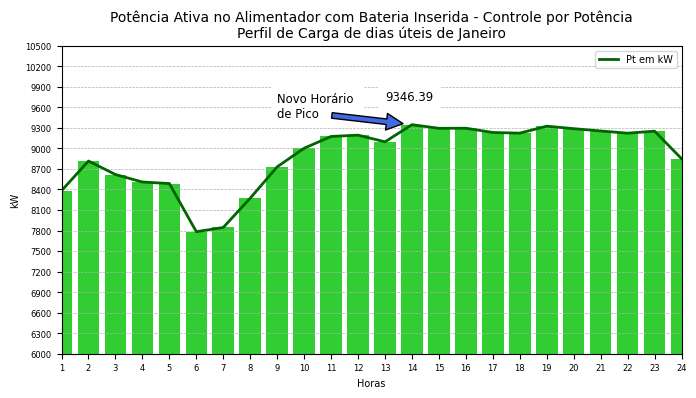

In [56]:
# Gráfico de Potência Ativa Fornecida pelo Alimentador
x = list(range(1, 1 +len(pt1)))
y = pt1
plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "limegreen")
plt.plot(x,y, "darkgreen", label = 'Pt em kW',linewidth = 2)
plt.title(f"Potência Ativa no Alimentador com Bateria Inserida - Controle por Potência\nPerfil de Carga de dias úteis de {mes}", fontsize = "medium")
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(6000,10500)
plt.yticks(np.linspace(6000, 10500, 16, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.annotate('Novo Horário \nde Pico',
            fontsize = 'small',
            backgroundcolor='white',
            xy = (pt1.argmax()+1, pt1.max()),
            xytext = (pt1.argmax()-4, pt1.max()+110),
            )
plt.annotate("",
            xy = (pt1.argmax()+1, pt1.max()),
            fontsize = 'small',
            xytext = (pt1.argmax()-2.3, pt1.max()+150),
            arrowprops = dict(facecolor='royalblue', shrink=0.1),
            )
plt.annotate(text = repr(round(pt1.max(),2)),
            xy=(13,9700),
            fontsize='small',
            backgroundcolor='white',
            )
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()  

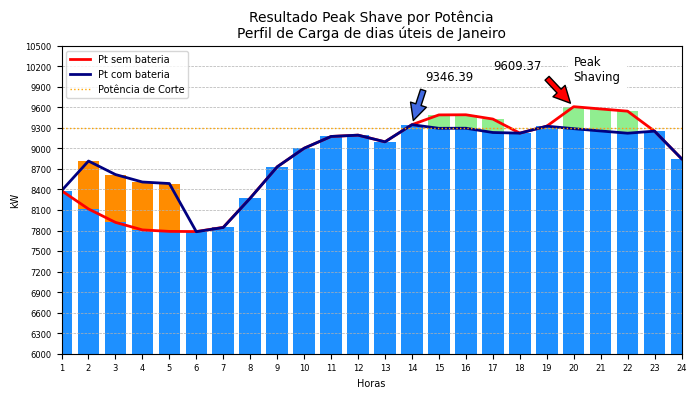

In [6]:
# Gráfico Comparativo - Com e Sem Bateria
x = list(range(1, 1 +len(pt)))
y = pt

x1 = list(range(1, 1 +len(pt1)))
y1 = pt1

ylim = []
for i in pt:
    ylim.append(9300)

plt.figure(figsize=(8, 4))
plt.bar(x1[:17],y1[:17],color = "darkorange")
plt.bar(x[:17],y[:17],color = "dodgerblue")
plt.bar(x[13:],y[13:],color = "lightgreen")
plt.bar(x1[13:],y1[13:],color = "dodgerblue")
plt.plot(x,y, "r", label = 'Pt sem bateria',linewidth = 2)
plt.plot(x1,y1, "navy", label = 'Pt com bateria',linewidth = 2)
plt.plot(x,ylim, "orange", linestyle='dotted', label = 'Potência de Corte',linewidth = 1)
plt.title(f"Resultado Peak Shave por Potência\nPerfil de Carga de dias úteis de {mes}",fontsize = 'medium')
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='upper left')
plt.xlim(1,24)
plt.ylim(6000,10500)
plt.yticks(np.linspace(6000, 10500, 16, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})


plt.annotate(text = repr(round(pt.max(),2)),
            xy = (pt.argmax()+1, pt.max()),
            fontsize = 'small',
            xytext = (pt.argmax()-2, pt.max()+550),
            arrowprops = dict(facecolor='red', shrink=0.1),
            )
plt.annotate(text = repr(round(pt1.max(),2)),
            xy = (pt1.argmax()+1, pt1.max()),
            fontsize = 'small',
            xytext = (pt1.argmax()+1.5, pt1.max()+650),
            arrowprops = dict(facecolor='royalblue', shrink=0.1),
            )
plt.annotate(text = "Peak\nShaving" ,
            xy=(20,10000),
            fontsize='small',
            backgroundcolor='white',
            )
plt.show()

In [28]:
# Resumo Energia Despachada

print(np.round((pt[11:17]-pt1[11:17]),2))
print(np.round((pt[17:]-pt1[17:]),2))
print(round((pt[19]-pt1[19]),2))
desp_1 = round(np.sum((pt[11:17]-pt1[11:17])),2)
desp_2 = round(np.sum((pt[17:]-pt1[17:])),2)
desp_pShaving = round((pt[19]-pt1[19]),2)
print(f"A energia ativa despachada pela bateria no pico da tarde é de {desp_1} kWh e no pico da noite é de {desp_2} kW")
print(f"No horário de pico, a potência cortada pela bateria é de {desp_pShaving} kW")

[  0.     0.     0.   196.02 196.49 196.48]
[ 3.6000e-01 -0.0000e+00  3.2130e+02  3.2174e+02  3.2177e+02 -7.0000e-01
 -2.0000e-02]
321.3
A energia ativa despachada pela bateria no pico da tarde é de 588.99 kWh e no pico da noite é de 964.45 kW
No horário de pico, a potência cortada pela bateria é de 321.3 kW


In [27]:
# Ativando Monitor de Potência na Bateria
dss.text("Export monitors Storage1")
dss.monitors_write_name("Storage1")
Storage_kWh = dss.monitors_channel(1)
Storage_State = dss.monitors_channel(2)
Storage_kWhOut = dss.monitors_channel(3)
Storage_kWIn = dss.monitors_channel(4)
Storage_kvarOut = dss.monitors_channel(5)

In [79]:
# Ativando o medidor do ramal de alimentação
dss.meters_write_name("m1_b")
reg_meters_names = dss.meters_register_names()
reg_meters_values = dss.meters_register_values()
reg_meters_values = list(map(lambda x: round(x, 2), reg_meters_values))
meters = pd.DataFrame(reg_meters_names, columns=["Medidas"])
meters["Valores"] = reg_meters_values
meters = meters.set_index("Medidas")
meters = meters[(meters['Valores']!=0)]
meters.to_excel(f'C:\Projeto_Final\Tabelas_e_imagens\medidores_{mes_}_u_p.xlsx')

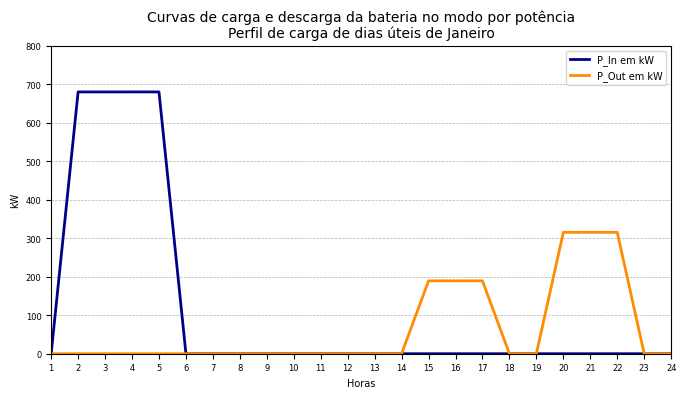

In [29]:
# Curvas de carga e descarga da bateria
x = list(range(1, 1 +len(Storage_kWhOut)))
y1 = Storage_kWIn
y2 = Storage_kWhOut
plt.figure(figsize=(8, 4))
plt.plot(x,y1, "darkblue", label = 'P_In em kW',linewidth = 2)
plt.plot(x,y2, "darkorange", label = 'P_Out em kW',linewidth = 2)
plt.title(f"Curvas de carga e descarga da bateria no modo por potência\nPerfil de carga de dias úteis de {mes}",fontsize = 'medium')
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(0,800)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show() 

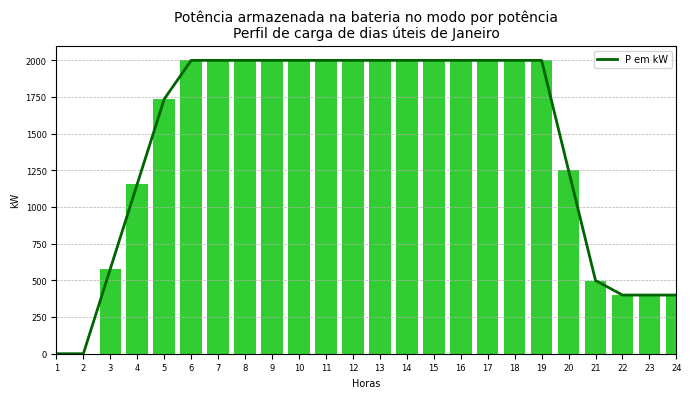

In [49]:
# Gráfico de Potência Ativa Fornecida pela Bateria
x = list(range(1, 1 +len(Storage_kWh)))
y = Storage_kWh
y1 = Storage_kvarOut
y2 = Storage_kWhOut

plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "limegreen")
plt.plot(x,y, "darkgreen", label = 'P em kW',linewidth = 2)
plt.title(f"Potência armazenada na bateria no modo por potência\nPerfil de carga de dias úteis de {mes}", fontsize = "medium")
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(0,2100)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()  

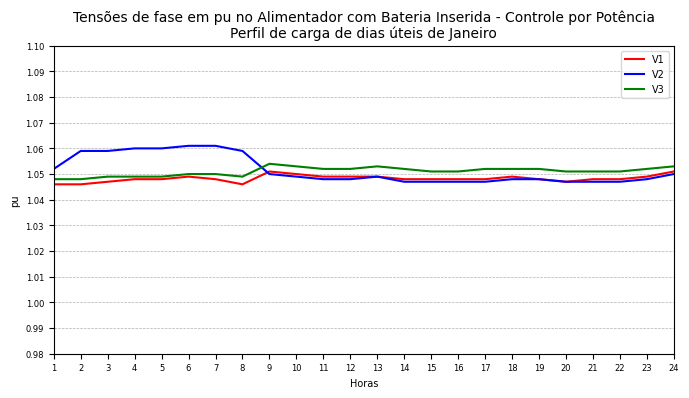

In [58]:
# Tensões em PU por Fase no Alimentador
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(v1b_pu))), v1b_pu, "r", label = 'V1')
plt.plot(list(range(1, 1 + len(v2b_pu))), v2b_pu, "b", label = 'V2')
plt.plot(list(range(1, 1 + len(v3b_pu))), v3b_pu, "g", label = 'V3')
plt.title(f"Tensões de fase em pu no Alimentador com Bateria Inserida - Controle por Potência\nPerfil de carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("pu")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(0.98,1.1)
plt.yticks(np.linspace(0.98, 1.1, 13, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

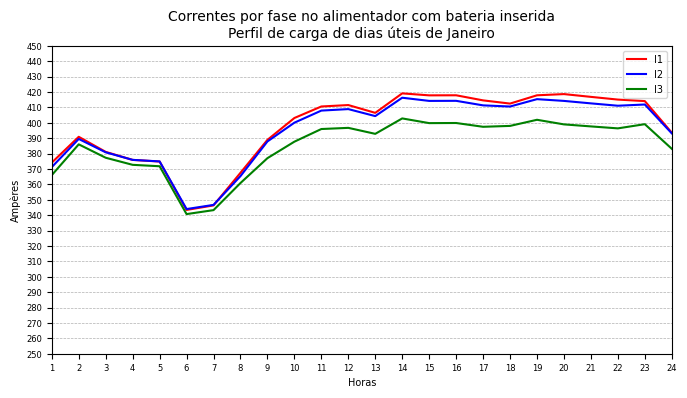

In [33]:
# Corrente por Fase no Alimentador com bateria inserida
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(i1_b))), i1_b, "r", label = 'I1')
plt.plot(list(range(1, 1 + len(i2_b))), i2_b, "b", label = 'I2')
plt.plot(list(range(1, 1 + len(i3_b))), i3_b, "g", label = 'I3')
plt.title(f"Correntes por fase no alimentador com bateria inserida\nPerfil de carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("Ampères")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(250,450)
plt.yticks(np.linspace(250, 450, 21, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

In [7]:
#-------------- CENÁRIO COM BATERIA - MODO PEAKSHAVE POR TEMPO --------------#

# Compilando arquivo com dados do sistema
dss.text("Clear")
dss.text("compile [{}]".format(dss_file))
# Inserindo um medidor de Energia no Alimentador que sai da subestação principal
alimentador = 'Line.ln5815900-1'
dss.text(f"New Energymeter.m1_b {alimentador} 1")
# Inserindo um monitor das grandezas elétricas no Alimentador que sai da subestação principal
dss.text(f"New Monitor.m1_power {alimentador} terminal=1 mode=1 ppolar=False")
dss.text(f"New Monitor.m1_voltage {alimentador} terminal=1 mode=0 ppolar=False")
# Definindo itens de controle e iterações do software
dss.text("Set Maxiterations=5000")
dss.text("Set maxcontrolit=5000")
# Carregando o LoadShape
loadshape = str(f"{n_mes}loadshape_{mes_}_u")
dss.text(f"New LoadShape.{loadshape} npts=24 interval=1 mult=(file={loadshape}.csv)")
#Definindo o LoadShape para todas as cargas
dss.text(f"Batchedit Load..* daily={loadshape}")

#dss.text("BatchEdit CapControl.. *enabled=False")
#dss.text("BatchEdit RegControl.. *enabled=False")

# Definindo a curva de eficiencia do inversor
dss.text("New XYCurve.Eff npts=4 xarray=[.1 .2 .4 1.0] yarray=[.86 .9 .93 .97]")

# Definindo a Bateria
dss.text("New Storage.Storage1 phases=3 bus1=m1166366 kV=12.47 %idlingkW=1 kwrated=800 kwhrated=2000 dispmode=Time %stored=0 EffCurve=Eff vminpu=0.95 vmaxpu=1.05")
dss.text("New Monitor.Storage1 element=Storage.Storage1 mode=3")

# dss.text(f"New StorageController.Storage1 element={alimentador} terminal=1 modedis=peakShave MonPhase=AVG kwtarget=9300 modecharge=Time timeChargeTrigger=2 %rateCharge=85 %ratekW=80 timeDischargeTrigger=19 %reserve=0 eventlog=yes")
dss.text(f"New StorageController.Storage1 element={alimentador} terminal=1 modedis=Time MonPhase=AVG kwtarget=9300 modecharge=Time timeChargeTrigger=2 %rateCharge=85 %ratekW=80 timeDischargeTrigger=19 %reserve=0 eventlog=yes")

#resolvendo modo daily
#dss.text("Set maxcontroliter=2000")
dss.text("Set mode=daily")
dss.text("Set number=24")
dss.text("Set stepsize=1h")
dss.solution_solve()
dss.text("Show Eventlog")

# Ativando Monitor de Potência no Alimentador
dss.monitors_write_name("m1_power")
pa1 = dss.monitors_channel(1)
qa1 = dss.monitors_channel(2)
pb1 = dss.monitors_channel(3)
qb1 = dss.monitors_channel(4)
pc1 = dss.monitors_channel(5)
qc1 = dss.monitors_channel(6)
pt1 = np.array(pa1) + np.array(pb1) + np.array(pc1)
qt1 = np.array(qa1) + np.array(qb1) + np.array(qc1)

# Ativando o Monitor de Tensões e Correntes
dss.monitors_write_name("m1_voltage")
v1_b = np.round(np.array(dss.monitors_channel(1))/10**3, 3)
v2_b = np.round(np.array(dss.monitors_channel(3))/10**3, 3)
v3_b = np.round(np.array(dss.monitors_channel(5))/10**3, 3)
v1b_pu = np.round(np.array(dss.monitors_channel(1))*math.sqrt(3)/((10**3)*12.47), 3)
v2b_pu = np.round(np.array(dss.monitors_channel(3))*math.sqrt(3)/((10**3)*12.47), 3)
v3b_pu = np.round(np.array(dss.monitors_channel(5))*math.sqrt(3)/((10**3)*12.47), 3)
i1_b = np.round(np.array(dss.monitors_channel(7)), 3)
i2_b = np.round(np.array(dss.monitors_channel(9)), 3)
i3_b = np.round(np.array(dss.monitors_channel(11)), 3)

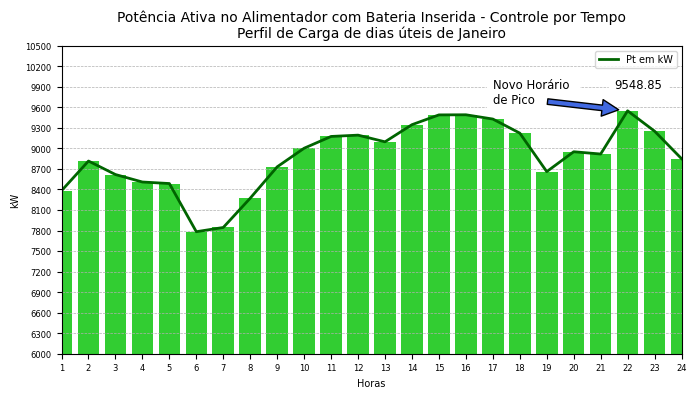

In [8]:
# Gráfico de Potência Ativa Fornecida pelo Alimentador
x = list(range(1, 1 +len(pt1)))
y = pt1
plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "limegreen")
plt.plot(x,y, "darkgreen", label = 'Pt em kW',linewidth = 2)
plt.title(f"Potência Ativa no Alimentador com Bateria Inserida - Controle por Tempo\nPerfil de Carga de dias úteis de {mes}", fontsize = "medium")
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(6000,10500)
plt.yticks(np.linspace(6000, 10500, 16, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.annotate('Novo Horário \nde Pico',
            fontsize = 'small',
            backgroundcolor='white',
            xy = (pt1.argmax()+1, pt1.max()),
            xytext = (pt1.argmax()-4, pt1.max()+110),
            )
plt.annotate("",
            xy = (pt1.argmax()+1, pt1.max()),
            fontsize = 'small',
            xytext = (pt1.argmax()-2.3, pt1.max()+150),
            arrowprops = dict(facecolor='royalblue', shrink=0.1),
            )
plt.annotate(text = repr(round(pt1.max(),2)),
            xy=(21.5,9880),
            fontsize='small',
            backgroundcolor='white',
            )
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()  

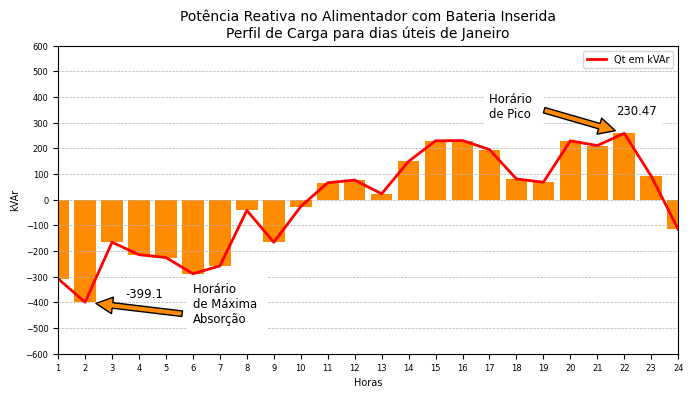

In [40]:
# Gráfico de Potência Reativa fornecida pelo Alimentador
x = list(range(1, 1 +len(qt1)))
y = qt1
plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "darkorange")
plt.plot(x,y, "red", label = 'Qt em kVAr',linewidth = 2)
plt.title(f"Potência Reativa no Alimentador com Bateria Inserida\nPerfil de Carga para dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("kVAr")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(-600,600)
plt.yticks(np.linspace(-600, 600, 13, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])

plt.annotate('Horário \nde Pico',
            fontsize = 'small',
            backgroundcolor='white',
            xy=(qt1.argmax()+1, qt1.max()),
            xytext=(qt1.argmax()-4, qt1.max()+60),
            )
plt.annotate("",
            xy = (qt1.argmax()+1, qt1.max()),
            fontsize = 'small',
            xytext = (qt1.argmax()-2.3, qt1.max()+100),
            arrowprops = dict(facecolor='darkorange', shrink=0.1)
            )
plt.annotate(text = repr(round(qt.max(),2)),
            xy=(21.7,330),
            fontsize = 'small',
            backgroundcolor='white'
            )
plt.annotate('Horário \nde Máxima \nAbsorção',
            fontsize = 'small',
            xy=(qt1.argmin()+1, qt1.min()),
            xytext=(qt1.argmin()+5, qt1.min()-80),
            backgroundcolor='white'
            )
plt.annotate("",
            xy = (qt1.argmin()+1, qt1.min()),
            fontsize = 'small',
            xytext = (qt1.argmin()+5, qt1.min()-50),
            arrowprops = dict(facecolor='darkorange', shrink=0.1)
            )
plt.annotate(text = repr(round(qt1.min(),2)),
            xy=(3.5,-380),
            fontsize = 'small'
            )
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

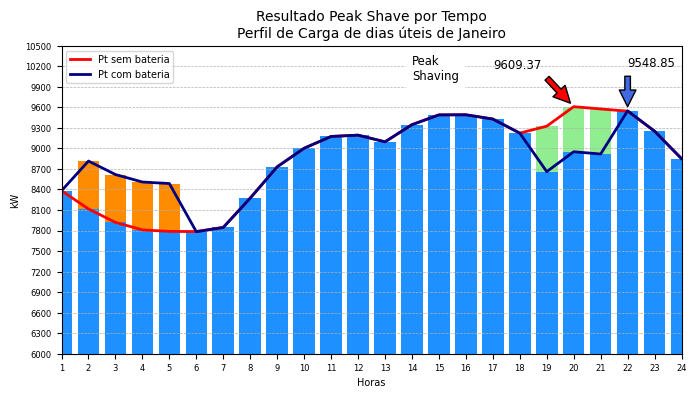

In [14]:
# Gráfico Comparativo - Com e Sem Bateria
x = list(range(1, 1 +len(pt)))
y = pt

x1 = list(range(1, 1 +len(pt1)))
y1 = pt1

plt.figure(figsize=(8, 4))
plt.bar(x1[:17],y1[:17],color = "darkorange")
plt.bar(x[:17],y[:17],color = "dodgerblue")
plt.bar(x[13:],y[13:],color = "lightgreen")
plt.bar(x1[13:],y1[13:],color = "dodgerblue")
plt.plot(x,y, "r", label = 'Pt sem bateria',linewidth = 2)
plt.plot(x1,y1, "navy", label = 'Pt com bateria',linewidth = 2)
plt.title(f"Resultado Peak Shave por Tempo\nPerfil de Carga de dias úteis de {mes}",fontsize = 'medium')
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='upper left')
plt.xlim(1,24)
plt.ylim(6000,10500)
plt.yticks(np.linspace(6000, 10500, 16, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})

plt.annotate(text = repr(round(pt.max(),2)),
            xy = (pt.argmax()+1, pt.max()),
            fontsize = 'small',
            xytext = (pt.argmax()-2, pt.max()+550),
            arrowprops = dict(facecolor='red', shrink=0.1),
            )
plt.annotate(text = repr(round(pt1.max(),2)),
            xy = (pt1.argmax()+1, pt1.max()),
            fontsize = 'small',
            xytext = (pt1.argmax()+1, pt1.max()+650),
            arrowprops = dict(facecolor='royalblue', shrink=0.1),
            )
plt.annotate(text = "Peak\nShaving" ,
            xy=(14,10000),
            fontsize='small',
            backgroundcolor='white',
            )
plt.show()

In [44]:
# Resumo Energia Despachada

print(np.round((pt[11:17]-pt1[11:17]),2))
print(np.round((pt[17:]-pt1[17:]),2))
print(round((pt[19]-pt1[19]),2))
desp_1 = round(np.sum((pt[11:17]-pt1[11:17])),2)
desp_2 = round(np.sum((pt[17:]-pt1[17:])),2)
desp_pShaving = round((pt[19]-pt1[19]),2)
print(f"A energia ativa despachada pela bateria no pico da tarde é de {desp_1} kWh e no pico da noite é de {desp_2} kW")
print(f"No horário de pico, a potência cortada pela bateria é de {desp_pShaving} kW")


[0. 0. 0. 0. 0. 0.]
[ 0.0000e+00  6.6390e+02  6.5852e+02  6.5857e+02 -5.1600e+00 -4.7000e-01
  2.0000e-02]
658.52
A energia ativa despachada pela bateria no pico da tarde é de 0.0 kWh e no pico da noite é de 1975.37 kW
No horário de pico, a potência cortada pela bateria é de 658.52 kW


In [45]:
# Ativando Monitor de Potência na Bateria
dss.text("Export monitors Storage1")
dss.monitors_write_name("Storage1")
Storage_kWh = dss.monitors_channel(1)
Storage_State = dss.monitors_channel(2)
Storage_kWhOut = dss.monitors_channel(3)
Storage_kWIn = dss.monitors_channel(4)
Storage_kvarOut = dss.monitors_channel(5)

In [81]:
# Ativando o medidor do ramal de alimentação
dss.meters_write_name("m1_b")
reg_meters_names = dss.meters_register_names()
reg_meters_values = dss.meters_register_values()
reg_meters_values = list(map(lambda x: round(x, 2), reg_meters_values))
meters = pd.DataFrame(reg_meters_names, columns=["Medidas"])
meters["Valores"] = reg_meters_values
meters = meters.set_index("Medidas")
meters = meters[(meters['Valores']!=0)]
meters.to_excel(f'C:\Projeto_Final\Tabelas_e_imagens\medidores_{mes_}_u_t.xlsx')

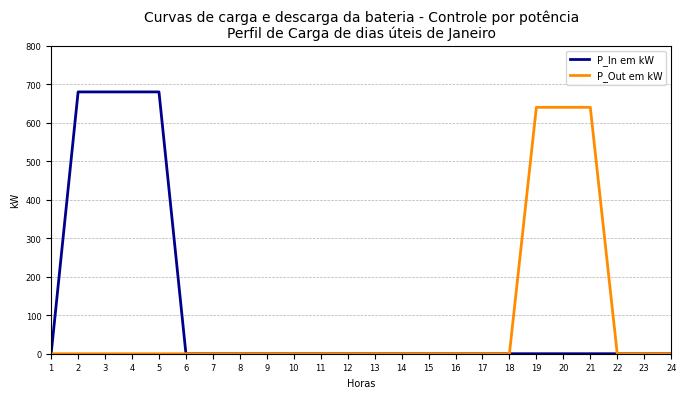

In [46]:
# Curvas de carga e descarga da bateria
x = list(range(1, 1 +len(Storage_kWhOut)))
y1 = Storage_kWIn
y2 = Storage_kWhOut
plt.figure(figsize=(8, 4))
plt.plot(x,y1, "darkblue", label = 'P_In em kW',linewidth = 2)
plt.plot(x,y2, "darkorange", label = 'P_Out em kW',linewidth = 2)
plt.title(f"Curvas de carga e descarga da bateria - Controle por potência\nPerfil de Carga de dias úteis de {mes}",fontsize = 'medium')
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(0,800)
plt.yticks(np.linspace(0, 800, 9, endpoint=True))
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

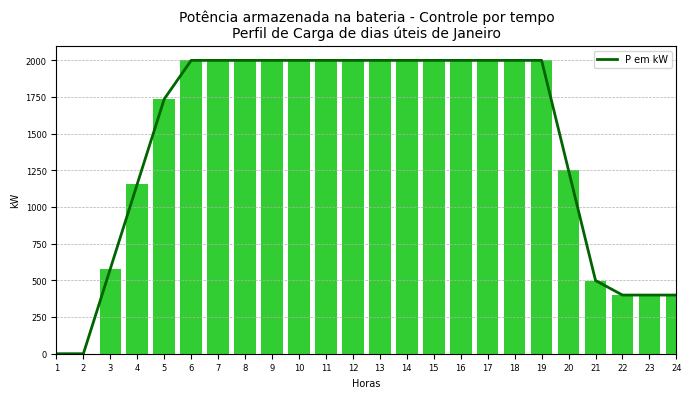

In [47]:
# Gráfico de Potência Ativa Fornecida pela Bateria
x = list(range(1, 1 +len(Storage_kWh)))
y = Storage_kWh
y1 = Storage_kvarOut
y2 = Storage_kWhOut

plt.figure(figsize=(8, 4))
plt.bar(x,y,color = "limegreen")
plt.plot(x,y, "darkgreen", label = 'P em kW',linewidth = 2)
plt.title(f"Potência armazenada na bateria - Controle por Tempo\nPerfil de Carga de dias úteis de {mes}", fontsize = "medium")
plt.ylabel("kW")
plt.xlabel("Horas")
plt.legend(loc='best')
plt.xlim(1,24)
plt.ylim(0,2100)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()  

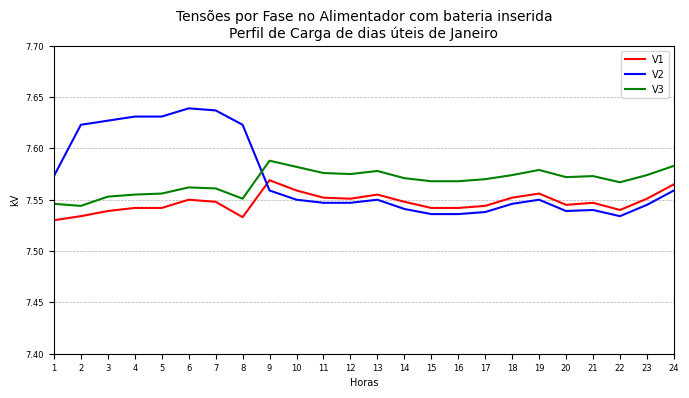

In [24]:
# Tensões por Fase no Alimentador com Bateria
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(v1_b))), v1_b, "r", label = 'V1')
plt.plot(list(range(1, 1 + len(v2_b))), v2_b, "b", label = 'V2')
plt.plot(list(range(1, 1 + len(v3_b))), v3_b, "g", label = 'V3')
plt.title(f"Tensões por Fase no Alimentador com bateria inserida\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("kV")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(7.4,7.7)
plt.yticks(np.linspace(7.4, 7.7, 7, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

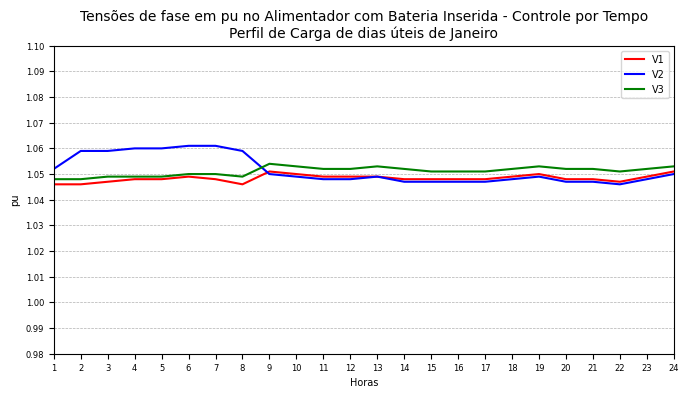

In [64]:
# Tensões em PU por Fase no Alimentador
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(v1b_pu))), v1b_pu, "r", label = 'V1')
plt.plot(list(range(1, 1 + len(v2b_pu))), v2b_pu, "b", label = 'V2')
plt.plot(list(range(1, 1 + len(v3b_pu))), v3b_pu, "g", label = 'V3')
plt.title(f"Tensões de fase em pu no Alimentador com Bateria Inserida - Controle por Tempo\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("pu")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(0.98,1.1)
plt.yticks(np.linspace(0.98, 1.1, 13, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()

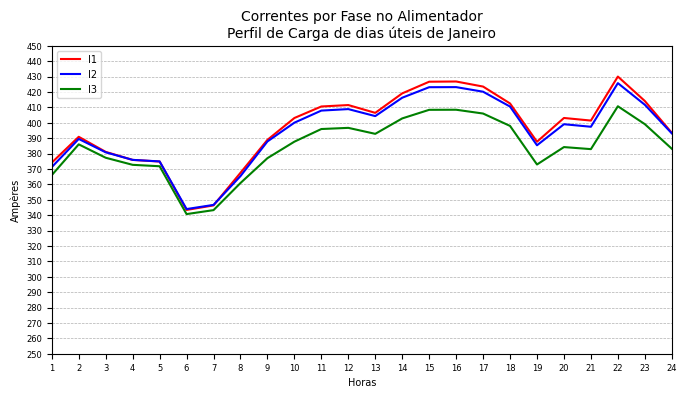

In [26]:
# Corrente por Fase no Alimentador com bateria inserida
plt.figure(figsize=(8, 4))
plt.plot(list(range(1, 1 + len(i1_b))), i1_b, "r", label = 'I1')
plt.plot(list(range(1, 1 + len(i2_b))), i2_b, "b", label = 'I2')
plt.plot(list(range(1, 1 + len(i3_b))), i3_b, "g", label = 'I3')
plt.title(f"Correntes por Fase no Alimentador\nPerfil de Carga de dias úteis de {mes}", fontsize = 'medium')
plt.ylabel("Ampères")
plt.xlabel("Horas")
plt.legend()
plt.xlim(1,24)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
plt.ylim(250,450)
plt.yticks(np.linspace(250, 450, 21, endpoint=True))
plt.grid(axis='y',linestyle='--',linewidth=0.5)
plt.rcParams.update({
    "axes.labelsize": 7,
    "font.size": 10,
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})
plt.show()